# Bayesball: Building a Predictive Model of the 2018 Baseball Season

Sam Myers, Olin College

[MIT License](https://opensource.org/licenses/MIT)

Baseball is unique among the major competitive sports in that there is an unparalleled amount of game data available for scrutiny. Not only does each season have a staggering 162 games, the methodical and granular nature of the gameplay lends itself particularly well to statistical tracking and analysis.

In this sequence of computational experiments, we attempt to infer a measure of each MLB team's "true" quality based on their measured performance during the 2018 baseball season. Furthermore, we will attempt to ascertain the "legitimacy" of the dominance of the Boston Red Sox as they jumped to the front of their division and followed that momentum all the way to a World Series victory.

In [122]:
from thinkbayes2 import Pmf, Cdf, Suite, MakeJoint
import thinkplot

import pymc3 as pm
import numpy as np
import pandas as pd

from pymc3.math import exp, log

from collections import Counter

def plotCdf(values, *args, **kwargs):
    thinkplot.Cdf(Cdf(values), *args, **kwargs)

Our data comes from Baseball Reference's "Team Game-by-Game Schedule" ([example here](https://www.baseball-reference.com/teams/BOS/2018-schedule-scores.shtml)) for each team, which means that we have two records of each game played (one on each opponent's schedule). This will actually be useful for our first model but a slight hindrance for the following ones.

In [21]:
team_names = ['BOS', 'NYY', 'TBR', 'TOR', 'BAL']
team_games = {}
for team in team_names:
    data = pd.read_csv(f'../data/{team.lower()}.csv')
    df = data[['Date', 'Opp', 'W/L', 'Unnamed: 4', 'R', 'RA']]
    df = df.loc[df['Opp'].isin(team_names)]
    df = df.rename(index=str, columns={'Unnamed: 4': 'Home'})
    df['Home'] = df['Home'].apply(lambda x: False if x == '@' else True)
    team_games[team] = df

Also, for the sake of computational brevity, in this experiment we only look at the five teams in the AL East division. This should still be enough data to make some reasonable conclusions, but is worth acknowledging because it changes the validation of our results a bit.

### Preliminary Model

To perform these estimates, we'll be building an MCMC (Markov Chain Monte Carlo) model using the PyMC library and tracking our desired properties as random variables representing probability distributions. By doing so, the model should be able to build a Bayesian estimate of those variables.

First, we start with a couple of fundamental assumptions about the game of baseball:

In [117]:
class Baseball(object):
    """
    A Baseball object contains properties about fundamental properties of 
    the sport of Baseball itself, represented with PyMC3 distributions.
    """
    
    def __init__(self, name='baseball'):
        self.name = name
        
        self.mean_score = pm.Normal(f'{name}.mean_score', mu=4.45, sd=1) # Based on 2018 average
        self.home_field_advantage = pm.Exponential(f'{name}.home_field_advantage', lam=5)

We start with a prior estimate of the average number of runs a given team is expected to score in a given game, which was about 4.45 in 2018. We also assume that home field advantage is a non-negligible factor, and that we expect a given team to score some amount of additional runs while at home.

In [118]:
class Team(object):
    def __init__(self, name, baseball):
        self.name = name
        self.baseball = baseball
        
        self.quality = pm.Normal(f'{name}.quality', mu=0, sd=1)
        
    def model_game(self, opponent, homefield : bool, date, observed_runs_scored, observed_runs_allowed=None):
        expected_runs = self.baseball.mean_score * (exp(self.quality) / exp(opponent.quality))

        if homefield:
            expected_runs += self.baseball.home_field_advantage

        pm.Poisson(f'{date}_{self.name}', mu=expected_runs, observed=observed_runs_scored)

We model runs here as a Poisson process, which is parameterized by the skill of both teams as well as who has homefield advantage. In particular, we model the expected number of runs a given team will score in a game as

$$k_{baseball} * \frac{e^{skill_{you}}}{e^{skill_{opponent}}} + home\_field\_boost$$

where

\begin{cases} 
      home\_field\_boost > 0 & \text{Team is home} \\
      home\_field\_boost = 0 & \text{Team is away} \\
   \end{cases}
   
Note: this version of the model treats each game played as two separate observations, since we only care about the runs scored by one team at a time. This is a quirk that we'll address in the next model.

In [119]:
def model_season(num_games=15, dedupe=False):
    modeled_games = {}
    simple_results = {name: {'R': 0, 'RA': 0, 'W': 0, 'L': 0} for name in team_names}

    with pm.Model() as model:
        bb = Baseball()
        
        teams = {name: Team(name, bb) for name in team_names}
        
        for name, games in team_games.items():
            for index, game in games.head(num_games).iterrows():
                date = game['Date']
                opp = game['Opp']
                if not dedupe or not (opp, date) in modeled_games:
                    modeled_games[(name, date)] = True
                    teams[name].model_game(teams[opp], game['Home'], date, game['R'], game['RA'])
                if not (opp, date) in modeled_games:
                    if game['W/L'].startswith('W'):
                        simple_results[name]['W'] += 1
                        simple_results[opp]['L'] += 1
                    else:
                        simple_results[opp]['W'] += 1
                        simple_results[name]['L'] += 1
                    simple_results[name]['R'] += game['R']
                    simple_results[name]['RA'] += game['RA']
                    simple_results[opp]['R'] += game['RA']
                    simple_results[opp]['RA'] += game['R']
        
        # Inspect the prior distribution
        prior_trace = pm.sample_prior_predictive()
        # Infer the posterior distribution
        trace = pm.sample(2000, tune=1000, cores=4, nuts_kwargs=dict(target_accept=.95))
    
    return prior_trace, trace, simple_results

In [120]:
prior_trace_0, trace_0, simple_results = model_season()
# pm.traceplot(trace_0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [BAL.quality, TOR.quality, TBR.quality, NYY.quality, BOS.quality, baseball.home_field_advantage, baseball.mean_score]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:24<00:00, 490.39draws/s]
The number of effective samples is smaller than 25% for some parameters.


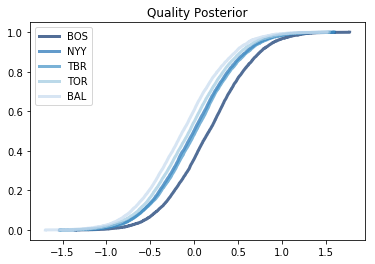

In [108]:
def plot_teams(trace, attr, title=''):
    for t in team_names:
        plotCdf(trace[f'{t}.{attr}'], label=t)
        thinkplot.Config(title=title)
    
plot_teams(trace_0, 'quality', 'Quality Posterior')

First we can take a look at our expected quality differential between teams, and get to the result that really matters:

0.933875 chance that BOS quality is better than NYY quality


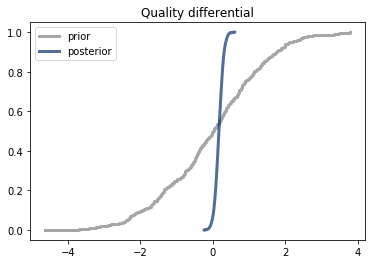

In [99]:
def plot_better(prior, posterior, better, worse, attr, attr_name):
    plotCdf(prior[f'{better}.{attr}'] - prior[f'{worse}.{attr}'], label='prior', color='grey')
    plotCdf(posterior[f'{better}.{attr}'] - posterior[f'{worse}.{attr}'], label='posterior')
    thinkplot.Config(title='Quality differential')

    win_chance=np.mean((posterior[f'{better}.{attr}'] - posterior[f'{worse}.{attr}'])>0)
    print(f'{win_chance} chance that {better} {attr_name} is better than {worse} {attr_name}')

plot_better(prior_trace_0, trace_0, 'BOS', 'NYY', 'quality', 'quality') # What really matters

Here we must resist the temptation to accept this result at face value, despite its consistency with some fundamental truths of baseball. What's interesting is that, despite the small sample size, our model is _very_ confident that Boston is better.

In [124]:
def compare_all(trace, attr, attr_name):
    best_teams = []
    for i in range(len(trace)):
        best_teams.append(max(team_names, key=lambda name: trace[f'{name}.{attr}'][i]))

    for team, count in Counter(best_teams).most_common():
        print(f'{team} {attr_name} is best with probability {count/len(trace)*100:.1f}%')\
        
compare_all(trace_0, 'quality', 'quality')

BOS quality is best with probability 86.7%
NYY quality is best with probability 5.8%
TBR quality is best with probability 4.9%
TOR quality is best with probability 2.4%
BAL quality is best with probability 0.4%


In fact, our model is so confident that there's a massive, 80 percent-ish gap between Boston and the lowly Yankees. If we look at [FiveThirtyEight's MLB predictions](https://projects.fivethirtyeight.com/2018-mlb-predictions/) from April 16th, which approximately lines up with how far into the season our analysis goes, their ELO-based team ratings only have the two teams separated by 10 points despite the win differential. Their model (also based on some secret Bayesian statistics) is pretty battle-tested, so this might be an indicator that the underlying numbers should give us closer results between the two teams.

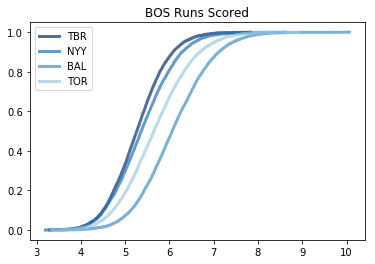

In [144]:
def plot_runs_h2h(team, trace, allowed=False):
    for opp in set(team_names) - set([team]):
        if allowed:
            runs = trace['baseball.mean_score'] * np.exp(trace[f'{opp}.quality'] - trace[f'{team}.quality'])
        else:
            runs = trace['baseball.mean_score'] * np.exp(trace[f'{team}.quality'] - trace[f'{opp}.quality'])
        plotCdf(runs, label=opp)
        
    thinkplot.Config(title=f'{team} Runs {"Allowed" if allowed else "Scored"}')
    
plot_runs_h2h('BOS', trace_0)

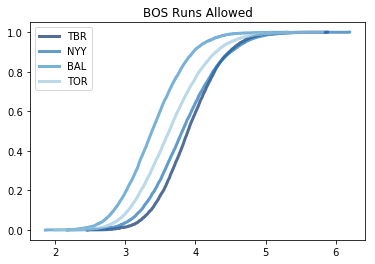

In [145]:
plot_runs_h2h('BOS', trace_0, allowed=True)

Here we also see that Boston is probably expected to score at least 5 runs against any of these AL East pitching staffs, and that the rest of them probably won't fare nearly as well against Boston pitching. Again, the gap is substantial.

For some validation, we can look at a traditional statistical look at the part of the season we're analyzing:

In [168]:
def print_simple_results(results):
    print('Team\tGames\tWin %\tRuns Scored per game\tRuns Allowed per game\tRun diff')
    for name in sorted(team_names, key=lambda x: results[x]['W'], reverse=True):
        num_games = results[name]['W'] + results[name]['L']
        win_pct = '{:.3f}'.format(results[name]['W'] / num_games)
        rpg = '{:.2f}'.format(results[name]['R'] / num_games)
        rapg = '{:.2f}'.format(results[name]['RA'] / num_games)
        rdiff = '{:.2f}'.format(float(rpg) - float(rapg))
        print(f'{name}\t{num_games}\t{win_pct}\t{rpg}\t\t\t{rapg}\t\t\t{rdiff}')

print_simple_results(simple_results)

Team	Games	Win %	Runs Scored per game	Runs Allowed per game	Run diff
BOS	19	0.737	5.42			3.79			1.63
NYY	17	0.529	5.41			4.94			0.47
TBR	18	0.389	4.78			5.06			-0.28
TOR	15	0.400	3.53			4.33			-0.80
BAL	15	0.400	4.27			5.73			-1.46


It's important to note that, despite having the worst winning percentage, Tampa sticks around the middle of the pack in our model's assessment. This checks out since their run differential, bolstered by a passable offense, is also middle of the pack.

However, we know from looking at the schedule itself that the Red Sox got to play 10 of their first 15 games against the Rays, whose pitching staff allowed over 5 runs per game. So maybe that's inflating their numbers a bit, and since we're not tracking offense separate from defense this looks like a nuance that our model doesn't pick up on.

### Offense/Defense Model

In [125]:
class Baseball(object):
    """
    A Baseball object contains properties about fundamental properties of 
    the sport of Baseball itself, represented with PyMC3 distributions.
    """
    
    def __init__(self, name='baseball'):
        self.name = name
        
        self.mean_score = pm.Normal(f'{name}.mean_score', mu=4.45, sd=1) # Based on 2018 MLB season
        self.home_field_advantage = pm.Exponential(f'{name}.home_field_advantage', lam=5)
        
        self.offense_weight = pm.Normal(f'{name}.offense_weight', mu=1, sd=0.5)
        self.defense_weight = pm.Normal(f'{name}.defense_weight', mu=1, sd=0.5)
        
    def get_runs(self, team, opponent):
        return self.mean_score * exp(team.off_quality * self.offense_weight - opponent.def_quality * self.defense_weight)

Our second iteration makes a couple of key modifications to the model. First and foremost, we separate a team's skill into offense and defense, which mirrors the actual game of baseball, where a team's pitching and hitting are largely independent, much more accurately.

We also build into the model the ability to learn whether these two metrics should be valued the same by assigning each of them a separate weight.

In [126]:
class Team(object):
    def __init__(self, name, baseball):
        self.name = name
        self.baseball = baseball
        
        self.off_quality = pm.Normal(f'{name}.off_quality', mu=0, sd=1)
        self.def_quality = pm.Normal(f'{name}.def_quality', mu=0, sd=1)

    def model_game(self, opponent, homefield : bool, date, observed_runs_scored=None, observed_runs_allowed=None):
        expected_runs_scored = self.baseball.get_runs(self, opponent)
        expected_runs_allowed = self.baseball.get_runs(opponent, self)

        if homefield:
            expected_runs_scored += self.baseball.home_field_advantage
        else:
            expected_runs_allowed += self.baseball.home_field_advantage

        pm.Poisson(f'{date}_{self.name}', mu=expected_runs_scored, observed=observed_runs_scored)
        pm.Poisson(f'{date}_{opponent.name}', mu=expected_runs_allowed, observed=observed_runs_allowed)

Our formula for runs is now

$$k_{baseball} * \frac{e^{a(offense_{you})}}{e^{b(defense_{opponent})}} + home\_field\_boost$$

where `a` and `b` represent the relative weights of our offensive and defensive parameters.

In [127]:
prior_trace_1, trace_1, _ = model_season(dedupe=True)
# pm.traceplot(trace_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [BAL.def_quality, BAL.off_quality, TOR.def_quality, TOR.off_quality, TBR.def_quality, TBR.off_quality, NYY.def_quality, NYY.off_quality, BOS.def_quality, BOS.off_quality, baseball.defense_weight, baseball.offense_weight, baseball.home_field_advantage, baseball.mean_score]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:32<00:00, 367.21draws/s]
The number of effective samples is smaller than 10% for some parameters.


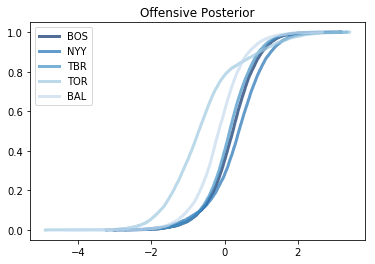

In [128]:
plot_teams(trace_1, 'off_quality', 'Offensive Posterior')

Now, Toronto is pretty bad, but for the most part the offenses are kind of clustered together. Notably, the trace that PyMC is running for this model has some divergences, which is why the Toronto offense looks both bad and weird. We'll see below that this graph might be a bit misleading for the bottom teams.

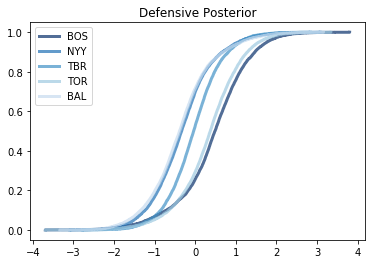

In [129]:
plot_teams(trace_1, 'def_quality', 'Defensive Posterior')

Boston pitching is now in front of the pack, with Toronto not far behind.

0.386875 chance that BOS offense is better than NYY offense


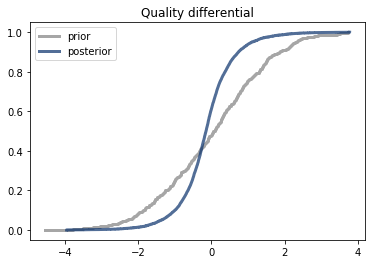

In [130]:
plot_better(prior_trace_1, trace_1, 'BOS', 'NYY', 'off_quality', 'offense')

This takes a little bit of picking apart. If we look at actual offensive numbers:

In [170]:
print_simple_results(simple_results)

Team	Games	Win %	Runs Scored per game	Runs Allowed per game	Run diff
BOS	19	0.737	5.42			3.79			1.63
NYY	17	0.529	5.41			4.94			0.47
TBR	18	0.389	4.78			5.06			-0.28
TOR	15	0.400	3.53			4.33			-0.80
BAL	15	0.400	4.27			5.73			-1.46


we see that Boston and New York are virtually the same. However, Boston is the only team that doesn't have to play against a pitching staff that only allows 3.79 runs per game, so New York probably gets a boost because of the quality differential there. The model is surprisingly pessimistic about the Red Sox offense, but it's not too certain about that and it kind of makes sense why.

0.805375 chance that BOS defense is better than NYY defense


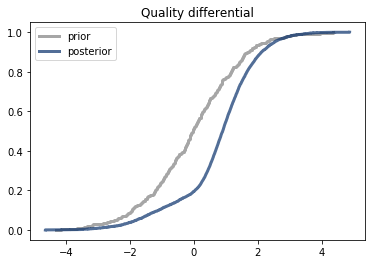

In [131]:
plot_better(prior_trace_1, trace_1, 'BOS', 'NYY', 'def_quality', 'defense')

And this is where the Red Sox appear to make up the difference on offense. Predictably, the model is more confident about Boston's superior pitching than it is about either team's hitting corps. We see more of that below, with numbers that reflect the clustered posterior distributions above:

In [139]:
compare_all(trace_1, 'off_quality', 'offense')

NYY offense is best with probability 41.3%
BOS offense is best with probability 21.4%
TBR offense is best with probability 16.6%
TOR offense is best with probability 15.8%
BAL offense is best with probability 4.9%


Even though Baltimore hitting isn't as bad as Toronto's based on their runs scored, a closer look at the schedule shows that the Orioles got the benefit of playing plenty of games against New York and Tampa's lousy pitching and still saw mediocre results. This is probably part of the reason they're lagging behind.

In [140]:
compare_all(trace_1, 'def_quality', 'defense')

BOS defense is best with probability 45.4%
TOR defense is best with probability 31.2%
BAL defense is best with probability 8.9%
TBR defense is best with probability 7.8%
NYY defense is best with probability 6.6%


This model's optimism about Toronto's pitching is borne out by them having the second-best runs allowed per game, but their abysmal offense explains their poor performance despite this.

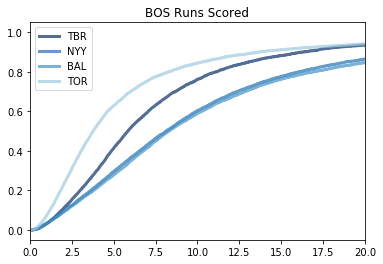

In [161]:
def plot_runs_h2h(team, trace, allowed=False, max_runs=10):
    for opp in set(team_names) - set([team]):
        if allowed:
            runs = trace['baseball.mean_score'] * np.exp(trace[f'{opp}.off_quality'] - trace[f'{team}.def_quality'])
        else:
            runs = trace['baseball.mean_score'] * np.exp(trace[f'{team}.off_quality'] - trace[f'{opp}.def_quality'])
        plotCdf(runs, label=opp)
        
    thinkplot.Config(title=f'{team} Runs {"Allowed" if allowed else "Scored"}', xlim=[0, max_runs])
    
plot_runs_h2h('BOS', trace_1, max_runs=20)

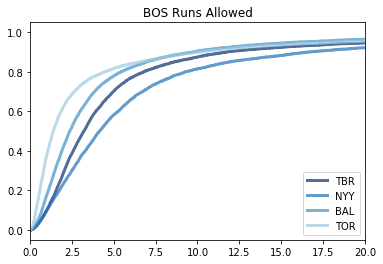

In [162]:
plot_runs_h2h('BOS', trace_1, allowed=True, max_runs=20)

These are admittedly weird. We can clearly see more probability mass on the right in the top graph, which is what we expect, but our model isn't incredibly confident that our scores will look like normal baseball games. This still needs a bit of work.

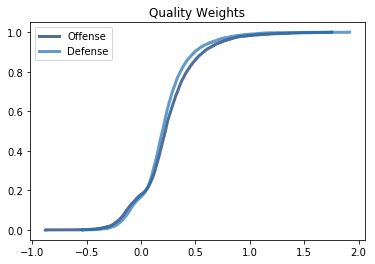

In [173]:
plotCdf(trace_1['baseball.offense_weight'], label='Offense')
plotCdf(trace_1['baseball.defense_weight'], label='Defense')
thinkplot.Config(title='Quality Weights')

Finally, we take a look at the weights of our offensive and defensive parameters. These are very close together, appear to be bimodal, and don't seem to be doing our model much good. Our next and final iteration will do away with them.

### Hierarchical Model

In [132]:
class Baseball(object):
    """
    A Baseball object contains properties about fundamental properties of 
    the sport of Baseball itself, represented with PyMC3 distributions.
    """
    
    def __init__(self, name='baseball'):
        self.name = name
        
        self.mean_score = pm.Normal(f'{name}.mean_score', mu=4.45, sd=1) # Based on 2018 MLB season
        self.home_field_advantage = pm.Exponential(f'{name}.home_field_advantage', lam=5)
        self.team_quality_sd = pm.Exponential(f'{name}.team_quality_sd', lam=1)
        
    def get_runs(self, team, opponent):
        return self.mean_score * exp(team.off_quality - opponent.def_quality)

As a final tweak, we reframe our abstraction of the game of baseball as a hierarchical model. Now we assume that there is some amount of variation in team skill inherent to the game, and our new model will attempt to learn what that is.

In [133]:
class Team(object):
    def __init__(self, name, baseball):
        self.name = name
        self.baseball = baseball

        self.off_quality = pm.Normal(f'{name}.off_quality', mu=0, sd=baseball.team_quality_sd)
        self.def_quality = pm.Normal(f'{name}.def_quality', mu=0, sd=baseball.team_quality_sd)

    def model_game(self, opponent, homefield : bool, date, observed_runs_scored=None, observed_runs_allowed=None):
        expected_runs_scored = self.baseball.get_runs(self, opponent)
        expected_runs_allowed = self.baseball.get_runs(opponent, self)

        if homefield:
            expected_runs_scored += self.baseball.home_field_advantage
        else:
            expected_runs_allowed += self.baseball.home_field_advantage

        pm.Poisson(f'{date}_{self.name}', mu=expected_runs_scored, observed=observed_runs_scored)
        pm.Poisson(f'{date}_{opponent.name}', mu=expected_runs_allowed, observed=observed_runs_allowed)

The rest of our game model is mostly the same, with the exception that we are now using the new property of baseball as the standard deviation for our team qualities.

In [134]:
prior_trace_2, trace_2, _ = model_season(dedupe=True)
# pm.traceplot(trace_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [BAL.def_quality, BAL.off_quality, TOR.def_quality, TOR.off_quality, TBR.def_quality, TBR.off_quality, NYY.def_quality, NYY.off_quality, BOS.def_quality, BOS.off_quality, baseball.team_quality_sd, baseball.home_field_advantage, baseball.mean_score]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:38<00:00, 312.29draws/s]
The number of effective samples is smaller than 25% for some parameters.


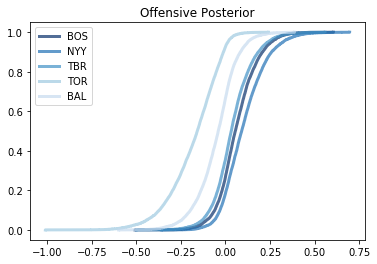

In [135]:
plot_teams(trace_2, 'off_quality', 'Offensive Posterior')

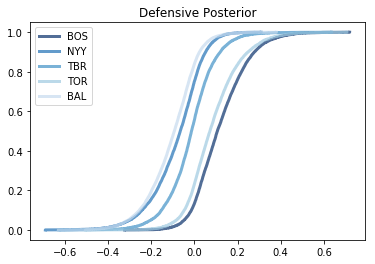

In [136]:
plot_teams(trace_2, 'def_quality', 'Defensive Posterior')

As hypothesized, removing offensive and defensive weights had little effect on the model beyond decreasing the uncertainty in our distributions.

0.3905 chance that BOS offense is better than NYY offense


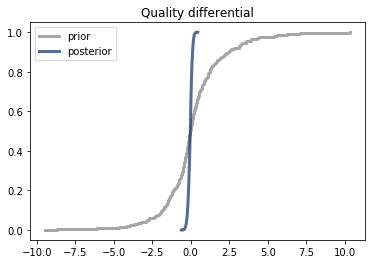

In [137]:
plot_better(prior_trace_2, trace_2, 'BOS', 'NYY', 'off_quality', 'offense')

0.9105 chance that BOS defense is better than NYY defense


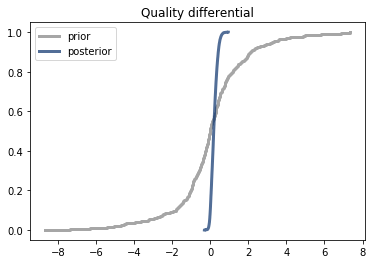

In [138]:
plot_better(prior_trace_2, trace_2, 'BOS', 'NYY', 'def_quality', 'defense')

Our results continue to tighten up. Note that the model is now less certain about offense, but more certain about defense.

In [165]:
compare_all(trace_2, 'off_quality', 'offense')

NYY offense is best with probability 44.9%
BOS offense is best with probability 29.6%
TBR offense is best with probability 19.4%
BAL offense is best with probability 4.8%
TOR offense is best with probability 1.3%


In [166]:
compare_all(trace_1, 'def_quality', 'defense')

BOS defense is best with probability 45.4%
TOR defense is best with probability 31.2%
BAL defense is best with probability 8.9%
TBR defense is best with probability 7.8%
NYY defense is best with probability 6.6%


Again, our new model gets rid of a bit of the noise and makes the gap between the two top offenses a bit smaller.

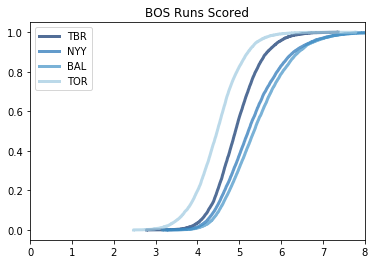

In [164]:
plot_runs_h2h('BOS', trace_2, max_runs=8)

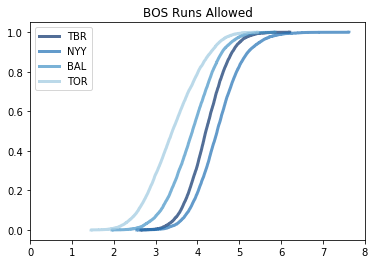

In [163]:
plot_runs_h2h('BOS', trace_2, allowed=True, max_runs=8)

Unlike the previous model, the hierarchical one gives us much more reasonable expectations about the score of a baseball game. We can pick out some individual results from here that seem consistent with actual 2018 games; we might expect a BOS-NYY game to be a higher scoring affair, while a BOS-TOR game is more likely to be relatively low-scoring.

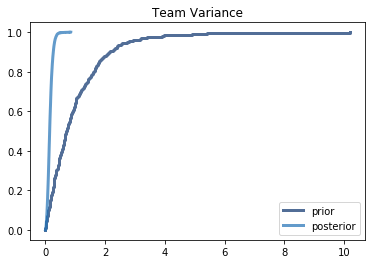

In [172]:
plotCdf(prior_trace_2['baseball.team_quality_sd'], label='prior')
plotCdf(trace_2['baseball.team_quality_sd'], label='posterior')
thinkplot.Config(title='Team Variance')

Finally, our variance in team skill actually appears to be pretty small. This is somewhat consistent with the results above, where no team's offense or defense has a majority of the "best" probability.

Hopefully this is a heartening result to those who yearn for more parity in baseball.